In [3]:
%matplotlib inline
import torch
from sebm.models import Discriminator_BIGAN, Encoder_BIGAN, Generator_GMM
dataset =  'cifar10' # 'svhn' # 'cifar10' # 'mnist' #  'flowers102' #
if dataset == 'mnist' or dataset =='fashionmnist':
    input_channels, im_height, im_width = 1, 28, 28
else:
    input_channels, im_height, im_width = 3, 32, 32
device = torch.device('cuda:0')
arch =  'simplenet'
reparameterized = True
seed = 1
lr = 2e-4
gmm_components = 50
if dataset == 'cifar10' or dataset == 'svhn':
    disc_channels, disc_kernels, disc_strides, disc_paddings = [64,128,256,512], [3,4,4,4], [1,2,2,2], [1,1,1,1]
    gen_channels, gen_kernels, gen_strides, gen_paddings = [512,256,128,64,3], [4,4,4,4,4], [2,2,2,2,2], [1,1,1,1,1]
    enc_channels, enc_kernels, enc_strides, enc_paddings = [64,128,256,512],[3,4,4,4], [1,2,2,2], [1,1,1,1]
    cnn_output_dim = 8192
    hidden_dim, latent_dim = [128], 128
    disc_activation, gen_activation = 'LeakyReLU', 'ReLU'
    leak, dropout = 0.2, 0.2
    
elif dataset == 'mnist' or dataset == 'fashionmnist':
    disc_channels, disc_kernels, disc_strides, disc_paddings = [64,64,32,32], [3,4,4,4], [1,2,2,2], [1,1,1,1]
    gen_channels, gen_kernels, gen_strides, gen_paddings = [64,64,32,32,1], [4,4,3,4,4], [1,2,2,2,2], [1,1,1,1,1] 
    enc_channels, enc_kernels, enc_strides, enc_paddings = [64,64,32,32], [3,4,4,4], [1,2,2,2], [1,1,1,1]
    cnn_output_dim = 288
    hidden_dim, latent_dim = [128], 128
    disc_activation, gen_activation = 'LeakyReLU', 'ReLU'
    leak, dropout = 0.2, 0.2
else:
    raise NotImplementError
data_dir = '../../../sebm_data/'
load_version = 'bigan_gmm-d=%s-seed=%d-lr=%s-zd=%d-disc_act=%s-gen_act=%s-arch=%s' % (dataset, seed, lr, latent_dim, disc_activation, gen_activation, arch)
arch= 'simplenet'
enc = Encoder_BIGAN(arch=arch,
                    reparameterized=reparameterized,
                    im_height=im_height, 
                    im_width=im_width, 
                    input_channels=input_channels, 
                    channels=enc_channels, 
                    kernels=enc_kernels, 
                    strides=enc_strides, 
                    paddings=enc_paddings, 
                    hidden_dim=hidden_dim,
                    latent_dim=latent_dim,
                    activation=disc_activation,
                    leak=leak,
                    last_act=False,
                    batchnorm=True)  

gen = Generator_GMM(arch=arch,
                    learn_prior=True,
                    K=gmm_components,
                    device=device,
                    im_height=1, 
                    im_width=1, 
                    input_channels=latent_dim, 
                    channels=gen_channels, 
                    kernels=gen_kernels, 
                    strides=gen_strides, 
                    paddings=gen_paddings, 
                    activation=gen_activation,
                    leak=leak,
                    batchnorm=True)

disc = Discriminator_BIGAN(arch=arch,
                           latent_dim=latent_dim,
                           cnn_output_dim=cnn_output_dim,
                           hidden_dim=hidden_dim,
                            im_height=im_height, 
                            im_width=im_width, 
                            input_channels=input_channels, 
                            channels=disc_channels, 
                            kernels=disc_kernels, 
                            strides=disc_strides, 
                            paddings=disc_paddings, 
                            activation=disc_activation,
                            leak=leak,
                            last_act=True,
                            batchnorm=True,
                            dropout=dropout)   

enc = enc.cuda().to(device)
gen = gen.cuda().to(device)
disc = disc.cuda().to(device)
print('Loading trained weights..')
enc.load_state_dict(torch.load('../weights/cp-%s' % load_version)['enc_state_dict'])
gen.load_state_dict(torch.load('../weights/cp-%s' % load_version)['gen_state_dict'])
disc.load_state_dict(torch.load('../weights/cp-%s' % load_version)['disc_state_dict'])

Loading trained weights..


<All keys matched successfully>

plotting the samples..


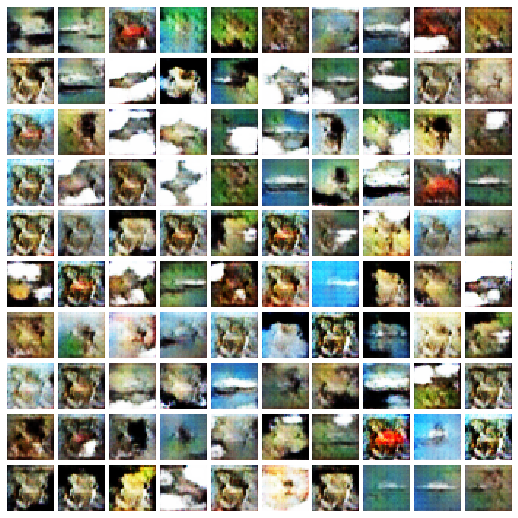

In [4]:
from sebm.eval import Evaluator_GAN, fewshots
evaluator = Evaluator_GAN((disc, gen, enc), device, dataset, data_dir)
evaluator.plot_samples(100)

In [5]:
fewshots(model_name='bigan_gmm', evaluator=evaluator)

  0%|          | 0/4 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


 25%|██▌       | 1/4 [00:33<01:39, 33.02s/it]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


 50%|█████     | 2/4 [01:06<01:06, 33.17s/it]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


 75%|███████▌  | 3/4 [01:44<00:34, 34.74s/it]

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 4/4 [04:41<00:00, 77.42s/it]


In [ ]:
similarity_z_space(evaluator, 
                       train_batch_size=2000, 
                       test_batch_size=2000,
                       model_name='igebm')

In [ ]:
from sebm.util import cnn_output_shape
cnn_output_shape(h=28,w=28, kernels=[4,4,4,4,4],strides=[1,2,2,2,2], paddings=[1,1,1,1,1])

In [ ]:
# scores = evaluator.oodauc(dataset_ood='texture', score='gradient')
# scores

In [ ]:
images_ebm = evaluator.uncond_sampling(batch_size=100, 
                                          sgld_steps=1000,
                                          sgld_lr=2.0,
                                          sgld_noise_std=1e-3,
                                          grad_clipping=False,
                                          init_samples=None,
                                          logging_interval=None)
evaluator.plot_final_samples(images_ebm, fs=5)

In [ ]:
evaluator.plot_oods(dataset_ood='cifar10', score='gradient',train=False, fs=4, save=False)